## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [5]:
import sys
sys.path.append("../../h2o-py/build/main") # path to h2o build

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

In [44]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 3 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [8]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99
                                                )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [9]:
max_depths = []

In [10]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [11]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpie4qcadb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpie4qcadb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpie4qcadb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='maurever_PUBDEV-4940_uplift_trees_poc',lastCommitHash='2d03b1b6186f410aed0fc8f8dce009157e3c53bc',gitDescribe='jenkins-master-5486-65-g2d03b1b618-dirty',compiledOn='2021-08-10 12:08:13',compiledBy='potte'


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_vy6vz3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.722617149353027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.115615367889404s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.073580741882324s
H2O session _sid_b1bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuv_6crcc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuv_6crcc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuv_6crcc\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_ae4d5y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.028501510620117s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.97057056427002s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.466151237487793s
H2O session _sid_8e4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcoxezygr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcoxezygr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcoxezygr\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_m3eqvm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.065911054611206s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.5782151222229s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.46068835258484s
H2O session _sid_8b2a closed.
Uplift 18.93900990486145s
RF 11.888133684794107s
gbm 23.333473443984985s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5iv43ja5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5iv43ja5\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_hgnzpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.26917290687561s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.328560590744019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.36642861366272s
H2O session _sid_8694 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwcglpdr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwcglpdr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwcglpdr_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_mvsqid
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 20.18598461151123s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.152808666229248s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.514097452163696s
H2O session _sid_acc1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg6lchs99
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg6lchs99\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg6lchs99\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_clks1p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.450315952301025s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.857405185699463s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.170936107635498s
H2O session _sid_b897 closed.
Uplift 19.30182449022929s
RF 11.446258147557577s
gbm 20.683820724487305s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptz594dcz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptz594dcz\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_potte_if2h9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 21.989222764968872s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.659119129180908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.86955165863037s
H2O session _sid_bb9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0l4o55wq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0l4o55wq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0l4o55wq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_potte_lgicfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 18.87234091758728s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.897783756256104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.897544145584106s
H2O session _sid_baf3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplya1dwia
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplya1dwia\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplya1dwia\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_uccmpt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.666583776474s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.23092770576477s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.719614505767822s
H2O session _sid_a028 closed.
Uplift 26.17604915301005s
RF 12.26261019706726s
gbm 18.1622367699941s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7a2hbowr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7a2hbowr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_216x0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.003034114837646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.581552267074585s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.565911531448364s
H2O session _sid_a402 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl5b4n7zg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl5b4n7zg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl5b4n7zg\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_a288ih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.530254364013672s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.907518863677979s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.564634561538696s
H2O session _sid_be3b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5jk32ur4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5jk32ur4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5jk32ur4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_b5hd1a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 19.65908980369568s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.966579675674438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.629698038101196s
H2O session _sid_882d closed.
Uplift 19.397459427515667s
RF 10.151883602142334s
gbm 16.586748043696087s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3k4wgpp9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3k4wgpp9\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_k5ab8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 22.89534068107605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.840975999832153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.739102840423584s
H2O session _sid_8065 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeub2c28o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeub2c28o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeub2c28o\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_ftu57q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 22.557926654815674s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.058754682540894s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.756166219711304s
H2O session _sid_b401 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqg0cybp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqg0cybp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqg0cybp8\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_zk3w5j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |█████████████████████████████████████████████████████████████| (done) 100%
Uplift Time: 24.776316165924072s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.280423164367676s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.046050548553467s
H2O session _sid_bdb8 closed.
Uplift 23.40986116727193s
RF 14.39338461558024s
gbm 21.513773202896118s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjlbt9zdq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjlbt9zdq\h2o_potte_started_from_python.out
  JV

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_87yhmk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.67399549484253s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.155583143234253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.580703735351562s
H2O session _sid_9f3b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqy4o5jts
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqy4o5jts\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqy4o5jts\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_gftkbq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.500426530838013s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.273205518722534s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.159507513046265s
H2O session _sid_af53 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprsl2r3y6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprsl2r3y6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprsl2r3y6\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_6f7vfv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.035966634750366s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.16668939590454s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.408848762512207s
H2O session _sid_9e09 closed.
Uplift 29.07012955347697s
RF 16.53182601928711s
gbm 25.716353336970013s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpja6scp1l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpja6scp1l\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_g8pqke
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.02484583854675s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.33656072616577s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.51041769981384s
H2O session _sid_917f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfm6y93cg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfm6y93cg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfm6y93cg\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_ibw73e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.8984911441803s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.302241802215576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.254180908203125s
H2O session _sid_bcb3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa2uz5xm3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa2uz5xm3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa2uz5xm3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_kbru3d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.58904719352722s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.23635959625244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.69577169418335s
H2O session _sid_b209 closed.
Uplift 45.50412805875143s
RF 27.291720708211262s
gbm 41.82012343406677s
12 - Uplift = 18.93900990486145, RF = 11.888133684794107, gbm = 23.333473443984985
10 - Uplift = 19.30182449022929, RF = 11.446258147557577, gbm = 20.683820724487305
8 - Uplift = 26.17604915301005, RF = 12.26261019706726, gbm = 18.1622367699941
6 - Uplift = 19.397459427515667, RF = 10.151883602142334, gbm = 16.586748043696087
4 - Uplift = 23.40986116727193, RF = 14.39338461558024, gbm = 21.513773202896118
2 - Uplift = 29.0701

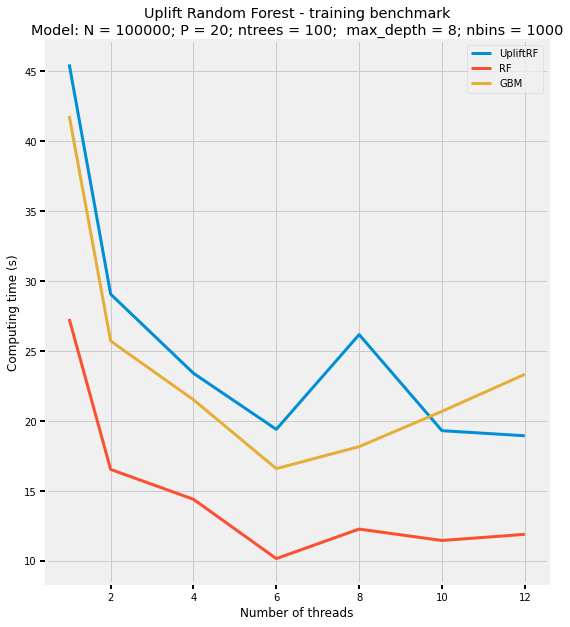

In [12]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [13]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [14]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1f9xjv9c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1f9xjv9c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1f9xjv9c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_hrkit7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.742013454437256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.7193865776062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 415.47888827323914s
H2O session _sid_84b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qorlof6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qorlof6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qorlof6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_5vmxre
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.88633155822754s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.72616600990295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 424.4862139225006s
H2O session _sid_ba96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvva4m7p9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvva4m7p9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvva4m7p9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_iu9lpe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.705761432647705s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 131.6882472038269s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 392.82195520401s
H2O session _sid_bb12 closed.
Uplift 26.778035481770832s
RF 137.3779332637787s
gbm 410.92901913324994s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn4ftzt3l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn4ftzt3l\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_wj951v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.560967922210693s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 129.94745588302612s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 357.47313475608826s
H2O session _sid_b012 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu99litt4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu99litt4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu99litt4\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_3q1bhq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.051595211029053s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 126.53720355033875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.1756293773651s
H2O session _sid_8547 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx5z60evy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx5z60evy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx5z60evy\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_ymenpm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.21346139907837s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 127.08784580230713s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 362.7482154369354s
H2O session _sid_aa3f closed.
Uplift 28.275341510772705s
RF 127.857501745224s
gbm 360.46565985679626s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp32_nt6t1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp32_nt6t1\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_zcjm09
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.135088443756104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 113.83161187171936s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 316.49980187416077s
H2O session _sid_a31d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmyicga5z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmyicga5z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmyicga5z\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_50vhze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.129355430603027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 113.85142397880554s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 318.63434624671936s
H2O session _sid_8bb4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3einreha
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3einreha\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3einreha\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_68fg5o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.928247690200806s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 115.76798462867737s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 315.8389678001404s
H2O session _sid_ae71 closed.
Uplift 28.730897188186646s
RF 114.48367349306743s
gbm 316.99103864034015s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpach7x8_7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpach7x8_7\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_a7es1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.663970470428467s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.98764944076538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 257.629714012146s
H2O session _sid_b065 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdhxlkupc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdhxlkupc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdhxlkupc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_9bruv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.64810872077942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.869544506073s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.70054626464844s
H2O session _sid_9fba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplc68velv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplc68velv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplc68velv\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_dzwpwj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.54777979850769s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.61562895774841s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 265.61973786354065s
H2O session _sid_9c19 closed.
Uplift 29.619952996571858s
RF 99.15760763486226s
gbm 260.983332713445s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn54235k5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn54235k5\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_r6owvx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.84544086456299s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.88404726982117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 218.2508783340454s
H2O session _sid_91c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpggljgcob
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpggljgcob\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpggljgcob\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_op3uyw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.5870521068573s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.3226318359375s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.96359848976135s
H2O session _sid_810e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpud_by2fq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpud_by2fq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpud_by2fq\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_y662c6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.51743984222412s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.54272317886353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 215.89106154441833s
H2O session _sid_8088 closed.
Uplift 31.316644271214802s
RF 85.58313409487407s
gbm 213.7018461227417s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnd92_p8h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnd92_p8h\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_om0xbw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.39304876327515s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.7268168926239s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.21283650398254s
H2O session _sid_83ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ygryzv2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ygryzv2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ygryzv2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_4t2dwm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.01728796958923s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.25963592529297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.63481950759888s
H2O session _sid_9293 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcdl589rh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcdl589rh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcdl589rh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_o7nrp8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.49331760406494s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.53927183151245s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.0504240989685s
H2O session _sid_ab94 closed.
Uplift 43.301218112309776s
RF 95.84190821647644s
gbm 205.63269337018332s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm432eqme
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm432eqme\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_gd4izy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.87483143806458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 153.04179334640503s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 289.07354640960693s
H2O session _sid_bf16 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd6dqckx1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd6dqckx1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd6dqckx1\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_dhq2s6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.79401898384094s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 155.03492712974548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 288.7539110183716s
H2O session _sid_bb0b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gk7nszs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gk7nszs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gk7nszs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_k2mrwc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.77218866348267s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 155.14588332176208s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.78933358192444s
H2O session _sid_b951 closed.
Uplift 75.48034636179607s
RF 154.4075345993042s
gbm 286.87226366996765s
12 - Uplift = 26.778035481770832, RF = 137.3779332637787, gbm = 410.92901913324994
10 - Uplift = 28.275341510772705, RF = 127.857501745224, gbm = 360.46565985679626
8 - Uplift = 28.730897188186646, RF = 114.48367349306743, gbm = 316.99103864034015
6 - Uplift = 29.619952996571858, RF = 99.15760763486226, gbm = 260.983332713445
4 - Uplift = 31.316644271214802, RF = 85.58313409487407, gbm = 213.7018461227417
2 - Uplift = 43.30

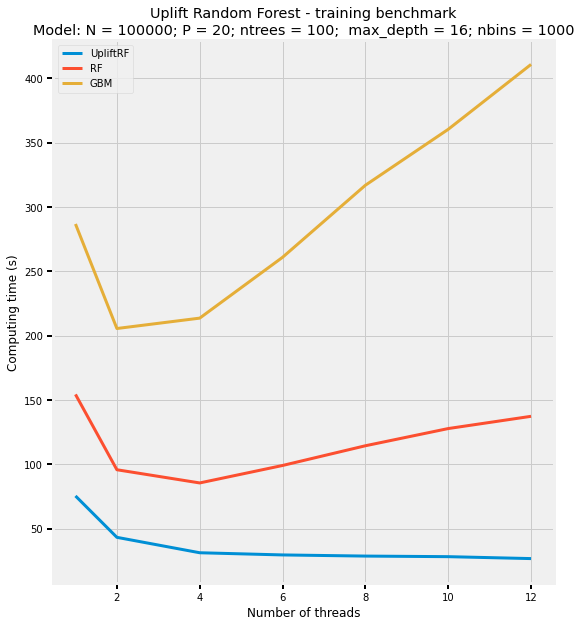

In [15]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [16]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [17]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpehae9833
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpehae9833\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpehae9833\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_vu4i43
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.874884605407715s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 151.27856850624084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 783.4567527770996s
H2O session _sid_bfce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1vmfe3yx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1vmfe3yx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1vmfe3yx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_49uvau
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.407164096832275s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 145.79611539840698s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 750.346203327179s
H2O session _sid_a6b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprq_fobq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprq_fobq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprq_fobq1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_rqfqqy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.465872526168823s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.57116889953613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 768.2931907176971s
H2O session _sid_b2a7 closed.
Uplift 30.582640409469604s
RF 147.881950934728s
gbm 767.3653822739919s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0a2t2l1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0a2t2l1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_y7aadn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.176897525787354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 130.56462717056274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 676.0578780174255s
H2O session _sid_96e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplkvck3l_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplkvck3l_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplkvck3l_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_sahtyr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.173200845718384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 131.094384431839s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 669.2006251811981s
H2O session _sid_aca3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxo_j7s62
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxo_j7s62\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxo_j7s62\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_0x3wf8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.18228793144226s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 131.13549971580505s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 665.4484860897064s
H2O session _sid_a109 closed.
Uplift 29.177462100982666s
RF 130.9315037727356s
gbm 670.23566309611s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2ly43rbq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2ly43rbq\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_o57bbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.022315979003906s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 126.37272357940674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 638.8222966194153s
H2O session _sid_acba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdgcde_rm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdgcde_rm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdgcde_rm\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_iel0ua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.397858142852783s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 124.32647228240967s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 624.9356625080109s
H2O session _sid_bb20 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcoupnk0m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcoupnk0m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcoupnk0m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_cy0zur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.970595121383667s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 128.35451793670654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 633.8964371681213s
H2O session _sid_a03a closed.
Uplift 32.13025641441345s
RF 126.35123793284099s
gbm 632.5514654318491s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzed3idns
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzed3idns\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_6vhmlx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.21953582763672s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 114.1943256855011s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 545.9850606918335s
H2O session _sid_91d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg1rbiuny
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg1rbiuny\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg1rbiuny\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_o0wt6t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 32.476649045944214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.36771965026855s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 536.4491393566132s
H2O session _sid_9627 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6a4vy6sx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6a4vy6sx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6a4vy6sx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_xjpd69
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.980583906173706s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 101.10981607437134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 522.0757029056549s
H2O session _sid_a3ce closed.
Uplift 31.55892292658488s
RF 109.22395380338033s
gbm 534.8366343180338s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc3xe5rf5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc3xe5rf5\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_fockrn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.58770203590393s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.51941800117493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 439.13747549057007s
H2O session _sid_ae5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnya8do4p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnya8do4p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnya8do4p\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_0skajw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.569440364837646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.32060718536377s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 429.2471444606781s
H2O session _sid_8b22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt1629a32
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt1629a32\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt1629a32\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_89qai8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.95876407623291s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.54526042938232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 430.8398940563202s
H2O session _sid_9e33 closed.
Uplift 33.371968825658165s
RF 97.12842853864034s
gbm 433.07483800252277s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_m1woqio
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_m1woqio\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_4bta9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.72569990158081s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 116.20155787467957s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 440.96440410614014s
H2O session _sid_a8cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp93osoo3u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp93osoo3u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp93osoo3u\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_4g5j1w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.02652311325073s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.34202170372009s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 435.37195229530334s
H2O session _sid_8c22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgv8m9gdh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgv8m9gdh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgv8m9gdh\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_10zapv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 52.46509337425232s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.72996926307678s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 446.47001218795776s
H2O session _sid_bca4 closed.
Uplift 51.07243879636129s
RF 118.42451628049214s
gbm 440.9354561964671s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp98c36lgu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp98c36lgu\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_uf6ac5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 87.06460785865784s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 183.5734782218933s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 564.4034872055054s
H2O session _sid_9f2d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq3ziqce_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq3ziqce_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq3ziqce_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_8n216k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 86.84657764434814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 187.11615300178528s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 566.488719701767s
H2O session _sid_a198 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwf_pp_og
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwf_pp_og\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwf_pp_og\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_e3m4tz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 83.97786545753479s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 174.6973912715912s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 535.2525060176849s
H2O session _sid_9a27 closed.
Uplift 85.96301698684692s
RF 181.79567416508993s
gbm 555.3815709749857s
12 - Uplift = 30.582640409469604, RF = 147.881950934728, gbm = 767.3653822739919
10 - Uplift = 29.177462100982666, RF = 130.9315037727356, gbm = 670.23566309611
8 - Uplift = 32.13025641441345, RF = 126.35123793284099, gbm = 632.5514654318491
6 - Uplift = 31.55892292658488, RF = 109.22395380338033, gbm = 534.8366343180338
4 - Uplift = 33.371968825658165, RF = 97.12842853864034, gbm = 433.07483800252277
2 - Uplift = 51.07243879

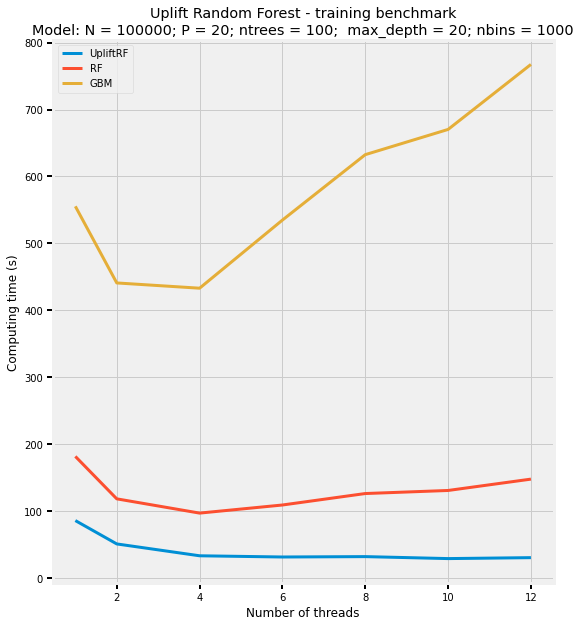

In [18]:
plot_result(uplift_time9, rf_time9, gbm_time9)

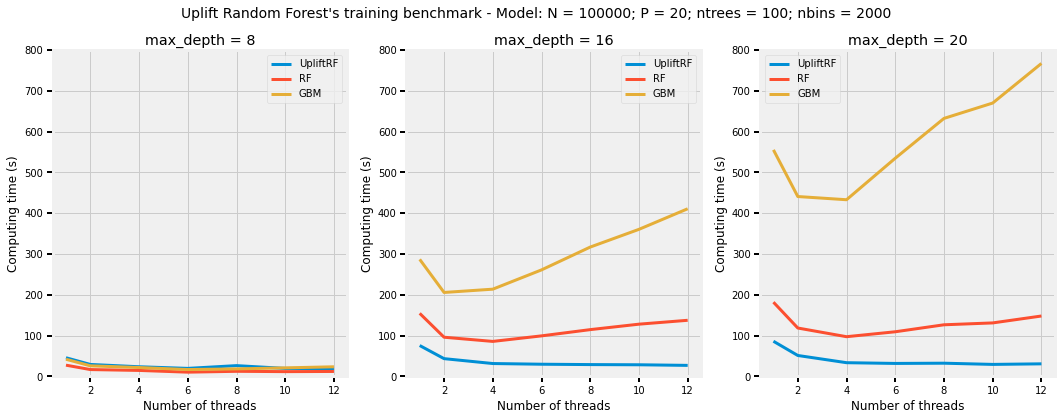

In [41]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [20]:
print(all_predict_uplift)

[{12: 18.93900990486145, 10: 19.30182449022929, 8: 26.17604915301005, 6: 19.397459427515667, 4: 23.40986116727193, 2: 29.07012955347697, 1: 45.50412805875143}, {12: 26.778035481770832, 10: 28.275341510772705, 8: 28.730897188186646, 6: 29.619952996571858, 4: 31.316644271214802, 2: 43.301218112309776, 1: 75.48034636179607}, {12: 30.582640409469604, 10: 29.177462100982666, 8: 32.13025641441345, 6: 31.55892292658488, 4: 33.371968825658165, 2: 51.07243879636129, 1: 85.96301698684692}]


In [21]:
print(all_predict_rf)

[{12: 11.888133684794107, 10: 11.446258147557577, 8: 12.26261019706726, 6: 10.151883602142334, 4: 14.39338461558024, 2: 16.53182601928711, 1: 27.291720708211262}, {12: 137.3779332637787, 10: 127.857501745224, 8: 114.48367349306743, 6: 99.15760763486226, 4: 85.58313409487407, 2: 95.84190821647644, 1: 154.4075345993042}, {12: 147.881950934728, 10: 130.9315037727356, 8: 126.35123793284099, 6: 109.22395380338033, 4: 97.12842853864034, 2: 118.42451628049214, 1: 181.79567416508993}]


In [22]:
print(all_predict_gbm)

[{12: 23.333473443984985, 10: 20.683820724487305, 8: 18.1622367699941, 6: 16.586748043696087, 4: 21.513773202896118, 2: 25.716353336970013, 1: 41.82012343406677}, {12: 410.92901913324994, 10: 360.46565985679626, 8: 316.99103864034015, 6: 260.983332713445, 4: 213.7018461227417, 2: 205.63269337018332, 1: 286.87226366996765}, {12: 767.3653822739919, 10: 670.23566309611, 8: 632.5514654318491, 6: 534.8366343180338, 4: 433.07483800252277, 2: 440.9354561964671, 1: 555.3815709749857}]


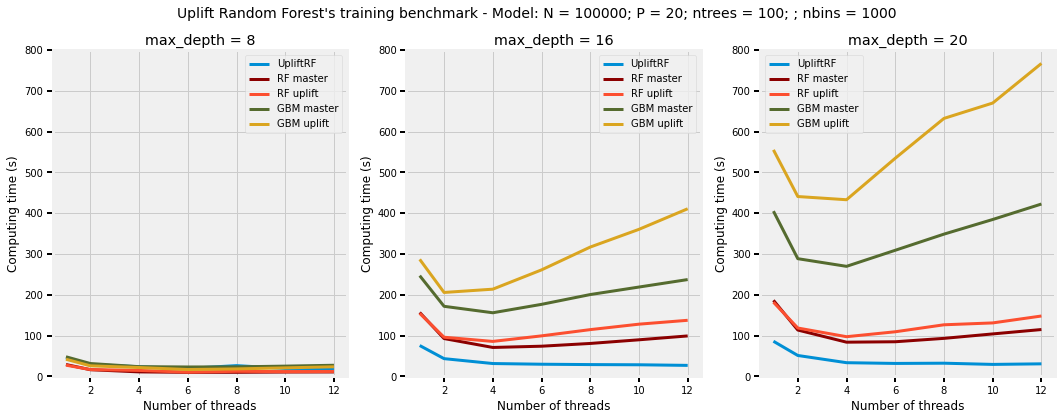

In [45]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 27.081815322240193, 10: 24.952803373336792, 8: 23.159403483072918, 6: 22.86972403526306, 4: 23.61972673734029, 2: 31.341749270757038, 1: 47.87071386973063}, {12: 237.26710589726767, 10: 218.92375540733337, 8: 200.5084115664164, 6: 176.47391653060913, 4: 155.84178606669107, 2: 171.66194248199463, 1: 246.81904776891074}, {12: 422.55340615908307, 10: 384.6162223815918, 8: 348.7189049720764, 6: 309.10822621981305, 4: 269.70600684483844, 2: 288.4865442117055, 1: 405.0667266845703}]
all_predict_rf_master = [{12: 10.641631603240967, 10: 10.478410482406616, 8: 9.805878162384033, 6: 9.723584095637003, 4: 10.819530407587687, 2: 16.16434113184611, 1: 28.905500809351604}, {12: 99.01363881429036, 10: 89.53205784161885, 8: 80.57155744234721, 6: 73.81262254714966, 4: 70.75689625740051, 2: 92.60285647710164, 1: 156.55289816856384}, {12: 114.71242904663086, 10: 103.93284972508748, 8: 93.05730152130127, 6: 84.7367049853007, 4: 83.69943340619405, 2: 113.46640475591023, 1: 186.4150514602661}]


fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkolivegreen")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [24]:
nbinss = []

In [25]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [26]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn33k0gi5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn33k0gi5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn33k0gi5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_etkel2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.57745623588562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.788667678833008s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 34.043142557144165s
H2O session _sid_8f06 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_gom4mgz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_gom4mgz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_gom4mgz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_ac7wqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.728917837142944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.29314088821411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 33.57716608047485s
H2O session _sid_8b28 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjs4sci3g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjs4sci3g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjs4sci3g\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_dshvub
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.648879766464233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.303219079971313s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 33.052818775177s
H2O session _sid_920d closed.
Uplift 27.651751279830933s
RF 22.79500921567281s
gbm 33.55770913759867s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuzkto4yw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuzkto4yw\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_l5yxjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.42002034187317s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.59762167930603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.490803241729736s
H2O session _sid_9485 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3rey2t9x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3rey2t9x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3rey2t9x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_wj3zv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.853384971618652s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.577008724212646s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.722113370895386s
H2O session _sid_ba96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvnmolpqq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvnmolpqq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvnmolpqq\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_5zxevd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.43072772026062s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.654109001159668s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.54525113105774s
H2O session _sid_a8dc closed.
Uplift 27.234711011250813s
RF 21.60957980155945s
gbm 31.586055914560955s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8x5apb_g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8x5apb_g\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_l5blly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.257460355758667s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.360689163208008s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.43036127090454s
H2O session _sid_add2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdy39db3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdy39db3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdy39db3n\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_dfxh8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.66447901725769s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.596224784851074s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.239521503448486s
H2O session _sid_876e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv6obyhg6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv6obyhg6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv6obyhg6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_kz2eop
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.266408920288086s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.550453186035156s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.634158849716187s
H2O session _sid_9dbe closed.
Uplift 27.729449431101482s
RF 21.502455711364746s
gbm 30.76801387468974s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpclcxlr9a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpclcxlr9a\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_4gqizn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.068705081939697s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.816452980041504s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 31.138706922531128s
H2O session _sid_8f7e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2f_xqol2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2f_xqol2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2f_xqol2\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ddb2ek
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.010906219482422s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.612668991088867s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.42289113998413s
H2O session _sid_b898 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpne2xd364
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpne2xd364\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpne2xd364\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_bby0au
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.45709204673767s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.18271493911743s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 33.06083941459656s
H2O session _sid_8814 closed.
Uplift 28.512234449386597s
RF 22.203945636749268s
gbm 31.540812492370605s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkq6w6eug
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkq6w6eug\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_uzen3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.635181665420532s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.24407196044922s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 34.012462854385376s
H2O session _sid_a3a2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp85ri6m8d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp85ri6m8d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp85ri6m8d\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours
H2O_cluster_name:,H2O_from_python_potte_c4pmw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.89578938484192s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.107422590255737s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 34.00712060928345s
H2O session _sid_9837 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpow3lk4fv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpow3lk4fv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpow3lk4fv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_vip7zb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.801163911819458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.185757637023926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 33.90811729431152s
H2O session _sid_ac13 closed.
Uplift 31.444044987360638s
RF 25.179084062576294s
gbm 33.97590025266012s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf00w_iio
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf00w_iio\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_h659qp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.8338885307312s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.49571895599365s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 51.137274742126465s
H2O session _sid_9469 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwmwxq5f9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwmwxq5f9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwmwxq5f9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_pslqt9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.79996633529663s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.12762379646301s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.44441747665405s
H2O session _sid_8c60 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0pwc3zn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0pwc3zn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0pwc3zn9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ymh24s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.55128502845764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.3892343044281s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 48.61001110076904s
H2O session _sid_a29c closed.
Uplift 45.72837996482849s
RF 39.33752568562826s
gbm 49.39723443984985s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdqusb3zl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdqusb3zl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_kyeba8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 78.49829387664795s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.24741435050964s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.4884045124054s
H2O session _sid_8a4f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyf9q0ssp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyf9q0ssp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyf9q0ssp\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_x2ykv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 78.49052619934082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.03223323822021s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.10063195228577s
H2O session _sid_900e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphkkxfkzy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphkkxfkzy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphkkxfkzy\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_ww8hvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 78.2258653640747s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.73670554161072s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.13156461715698s
H2O session _sid_b937 closed.
Uplift 78.40489514668782s
RF 71.3387843767802s
gbm 82.57353369394939s
12 - Uplift = 27.651751279830933, RF = 22.79500921567281, gbm = 33.55770913759867
10 - Uplift = 27.234711011250813, RF = 21.60957980155945, gbm = 31.586055914560955
8 - Uplift = 27.729449431101482, RF = 21.502455711364746, gbm = 30.76801387468974
6 - Uplift = 28.512234449386597, RF = 22.203945636749268, gbm = 31.540812492370605
4 - Uplift = 31.444044987360638, RF = 25.179084062576294, gbm = 33.97590025266012
2 - Uplift = 45.7283

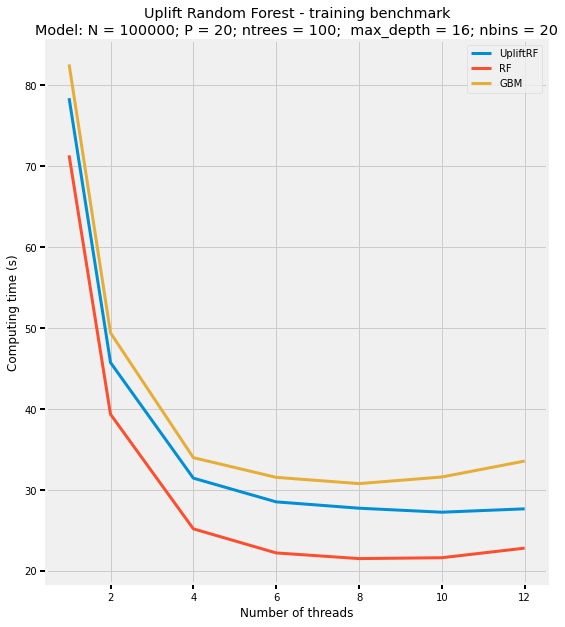

In [27]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [28]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [29]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5jddplld
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5jddplld\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5jddplld\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_yhf75r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.33288550376892s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.47704410552979s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 194.91958689689636s
H2O session _sid_b051 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp097kh2lj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp097kh2lj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp097kh2lj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_z9le67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.128029346466064s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.63984990119934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.92022609710693s
H2O session _sid_b70b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp25s_z6hu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp25s_z6hu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp25s_z6hu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_vn5ldt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.720601081848145s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.58576583862305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 197.92098665237427s
H2O session _sid_9e23 closed.
Uplift 27.39383864402771s
RF 66.56755328178406s
gbm 197.9202665487925s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0t30fbmd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0t30fbmd\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_h7x1yu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 25.94529128074646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.910598278045654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.470769405365s
H2O session _sid_a57b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphzb4ny3t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphzb4ny3t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphzb4ny3t\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_7cu1fc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.302627086639404s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.13386344909668s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.97960329055786s
H2O session _sid_9d80 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwl630rto
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwl630rto\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwl630rto\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_wbw0eh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 25.469873189926147s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.360214710235596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 144.4462604522705s
H2O session _sid_b976 closed.
Uplift 25.905930519104004s
RF 56.80155881245931s
gbm 143.9655443827311s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjl1v2f8m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjl1v2f8m\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_odv5eg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.556784629821777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.95942687988281s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.3982093334198s
H2O session _sid_97c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp35x9vbkq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp35x9vbkq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp35x9vbkq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_gmusmm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.694236993789673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.80058145523071s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.14305424690247s
H2O session _sid_ab61 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdq37w90t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdq37w90t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdq37w90t\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_oeys0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.751004457473755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.174365282058716s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.62885165214539s
H2O session _sid_835d closed.
Uplift 28.33400869369507s
RF 55.97812453905741s
gbm 135.05670507748923s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7v8jp8m8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7v8jp8m8\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_ekcahj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.480143785476685s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.1514937877655s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 118.35420298576355s
H2O session _sid_8159 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2236jyaa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2236jyaa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2236jyaa\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_boitak
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.977599620819092s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.15061664581299s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 117.32819652557373s
H2O session _sid_a99d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkvp6e426
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkvp6e426\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkvp6e426\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_aq14gc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.04347252845764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.552287340164185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 116.65614461898804s
H2O session _sid_8cde closed.
Uplift 28.500405311584473s
RF 51.28479925791422s
gbm 117.4461813767751s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp02k_aphz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp02k_aphz\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_b1ed60
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.21758508682251s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.97089171409607s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.52296018600464s
H2O session _sid_8668 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp18ayqa69
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp18ayqa69\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp18ayqa69\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_tqy3gd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.177234172821045s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.823537826538086s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 100.81114292144775s
H2O session _sid_803e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9w19g4mf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9w19g4mf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9w19g4mf\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_d0r1n5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.224388599395752s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 48.76925444602966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 100.75737881660461s
H2O session _sid_b51b closed.
Uplift 29.206402619679768s
RF 49.85456132888794s
gbm 101.363827308019s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjy3y97yv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjy3y97yv\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ldgd0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.8379590511322s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.49657416343689s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 112.25912261009216s
H2O session _sid_987e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7nhvxpb3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7nhvxpb3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7nhvxpb3\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_yhhdrn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 41.75910186767578s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.69986128807068s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 111.91672658920288s
H2O session _sid_b0e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeeer6ja5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeeer6ja5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeeer6ja5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_4eug33
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 41.576045751571655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.21966528892517s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 111.46240592002869s
H2O session _sid_80ad closed.
Uplift 42.05770222345988s
RF 64.13870024681091s
gbm 111.87941837310791s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp88gqqs3q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp88gqqs3q\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_2k8dwg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.91895747184753s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.1786732673645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 164.17693185806274s
H2O session _sid_9941 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8704p0w6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8704p0w6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8704p0w6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_jmv32s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 71.28494143486023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.2152955532074s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 163.30929350852966s
H2O session _sid_81e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_mne4xif
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_mne4xif\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_mne4xif\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_si9a2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.97570133209229s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.06694483757019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 167.7291615009308s
H2O session _sid_bc17 closed.
Uplift 72.39320007960002s
RF 105.82030455271403s
gbm 165.07179562250772s
12 - Uplift = 27.39383864402771, RF = 66.56755328178406, gbm = 197.9202665487925
10 - Uplift = 25.905930519104004, RF = 56.80155881245931, gbm = 143.9655443827311
8 - Uplift = 28.33400869369507, RF = 55.97812453905741, gbm = 135.05670507748923
6 - Uplift = 28.500405311584473, RF = 51.28479925791422, gbm = 117.4461813767751
4 - Uplift = 29.206402619679768, RF = 49.85456132888794, gbm = 101.363827308019
2 - Uplift = 42.057702

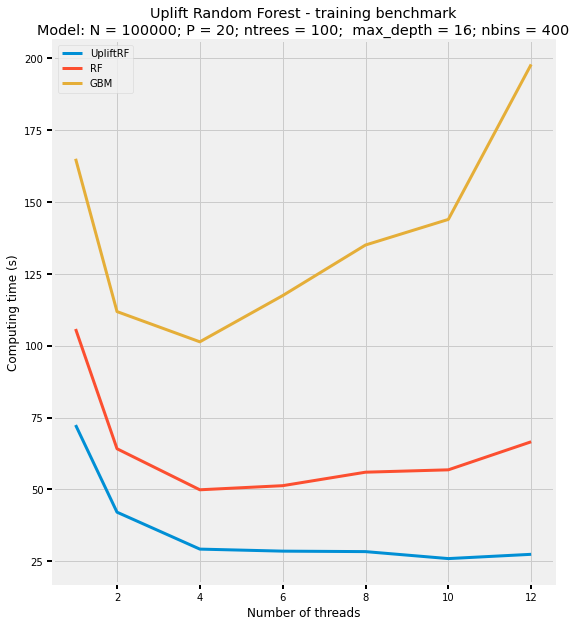

In [30]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [31]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [32]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxrqzn3zu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxrqzn3zu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxrqzn3zu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_m0i76a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.693774461746216s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 242.30447125434875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 999.8311302661896s
H2O session _sid_a381 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprl_8d3cf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprl_8d3cf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprl_8d3cf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_3v3qsm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.08020520210266s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 245.66257667541504s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 990.4633655548096s
H2O session _sid_b3ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplfg2sf04
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplfg2sf04\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplfg2sf04\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_rkem53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.004868030548096s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 242.87683725357056s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 933.8394155502319s
H2O session _sid_8837 closed.
Uplift 29.592949231465656s
RF 243.6146283944448s
gbm 974.7113037904104s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_xfpddfr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_xfpddfr\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours
H2O_cluster_name:,H2O_from_python_potte_53s1sr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 26.576152801513672s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 202.54715585708618s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 844.0608551502228s
H2O session _sid_a30d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8r19jiyw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8r19jiyw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8r19jiyw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_tzuylo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.506913900375366s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 205.68787932395935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 833.6965718269348s
H2O session _sid_9b53 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsv9he3dx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsv9he3dx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsv9he3dx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_73z2qv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.781752109527588s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 206.3969795703888s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 847.3676564693451s
H2O session _sid_b729 closed.
Uplift 27.288272937138874s
RF 204.87733825047812s
gbm 841.7083611488342s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc8ks39w5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc8ks39w5\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_rfkcx6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.750802516937256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 192.2303912639618s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 783.3349010944366s
H2O session _sid_a826 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvah1qx8c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvah1qx8c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvah1qx8c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_dv71nu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.868614673614502s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 191.26584768295288s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 789.2244391441345s
H2O session _sid_9626 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjqjvbei4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjqjvbei4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjqjvbei4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_re0u5x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 28.77263116836548s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 192.64199662208557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 733.9261541366577s
H2O session _sid_9abb closed.
Uplift 28.797349452972412s
RF 192.0460785230001s
gbm 768.8284981250763s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66gd3gtp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66gd3gtp\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_91n5ma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 29.743367671966553s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 162.32270216941833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 629.9285576343536s
H2O session _sid_a485 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpthvpez4s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpthvpez4s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpthvpez4s\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours
H2O_cluster_name:,H2O_from_python_potte_yald0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 27.90392780303955s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 151.63169860839844s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 620.0877692699432s
H2O session _sid_ab95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4m3mgwdf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4m3mgwdf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4m3mgwdf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_t0ns9k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 30.19553279876709s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 159.19907021522522s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 649.0420615673065s
H2O session _sid_8ad7 closed.
Uplift 29.280942757924397s
RF 157.71782366434732s
gbm 633.0194628238678s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqyq4l6zn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqyq4l6zn\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_fva8wz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.83059811592102s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.88687181472778s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 551.5396091938019s
H2O session _sid_a320 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpty4dk2cv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpty4dk2cv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpty4dk2cv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_565may
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.70155096054077s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.29900240898132s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 545.7323732376099s
H2O session _sid_a895 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi7eqctmj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi7eqctmj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi7eqctmj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_7qvwf8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 31.963484287261963s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.53696036338806s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 564.9677405357361s
H2O session _sid_a768 closed.
Uplift 31.831877787907917s
RF 147.57427819569907s
gbm 554.0799076557159s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm2x46l9g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm2x46l9g\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_mrlgzb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.837563276290894s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 162.0022256374359s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 494.9446060657501s
H2O session _sid_9d70 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpateapzek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpateapzek\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpateapzek\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_n7dyr0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.07739806175232s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 150.48967933654785s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 489.63170862197876s
H2O session _sid_ae3d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi85_kr1m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi85_kr1m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi85_kr1m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_bd0yfm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.055686473846436s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.9859185218811s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 502.42108392715454s
H2O session _sid_b220 closed.
Uplift 45.65688260396322s
RF 153.8259411652883s
gbm 495.6657995382945s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi4b9pxiw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi4b9pxiw\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_sgflkv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 77.29178595542908s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.85259461402893s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 609.6779820919037s
H2O session _sid_a3b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaawna9e7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaawna9e7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaawna9e7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_iqgwbh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.66842889785767s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 228.8864209651947s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 611.3536911010742s
H2O session _sid_832a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_dgf8jb5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_dgf8jb5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_dgf8jb5\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_kstf91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 78.31124663352966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 227.65985560417175s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 629.1354532241821s
H2O session _sid_b5de closed.
Uplift 77.42382049560547s
RF 227.1329570611318s
gbm 616.7223754723867s
12 - Uplift = 29.592949231465656, RF = 243.6146283944448, gbm = 974.7113037904104
10 - Uplift = 27.288272937138874, RF = 204.87733825047812, gbm = 841.7083611488342
8 - Uplift = 28.797349452972412, RF = 192.0460785230001, gbm = 768.8284981250763
6 - Uplift = 29.280942757924397, RF = 157.71782366434732, gbm = 633.0194628238678
4 - Uplift = 31.831877787907917, RF = 147.57427819569907, gbm = 554.0799076557159
2 - Uplift = 45.656

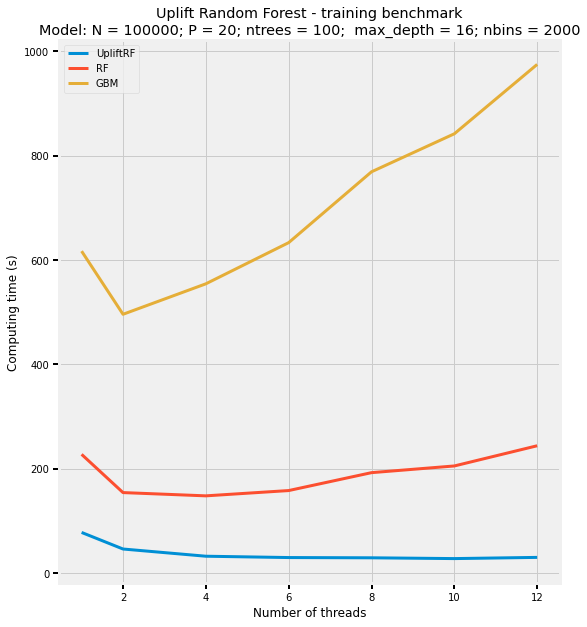

In [33]:
plot_result(uplift_time2, rf_time2, gbm_time2)

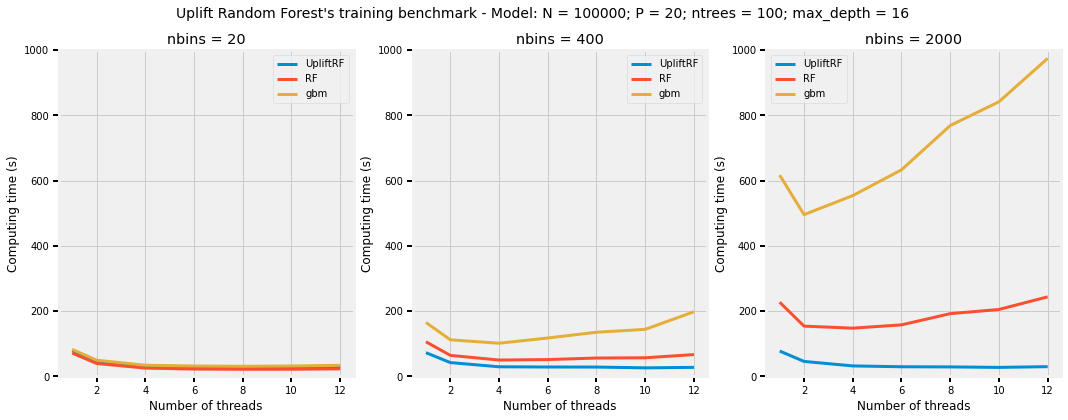

In [39]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [35]:
print(all_predict_uplift)

[{12: 27.651751279830933, 10: 27.234711011250813, 8: 27.729449431101482, 6: 28.512234449386597, 4: 31.444044987360638, 2: 45.72837996482849, 1: 78.40489514668782}, {12: 27.39383864402771, 10: 25.905930519104004, 8: 28.33400869369507, 6: 28.500405311584473, 4: 29.206402619679768, 2: 42.05770222345988, 1: 72.39320007960002}, {12: 29.592949231465656, 10: 27.288272937138874, 8: 28.797349452972412, 6: 29.280942757924397, 4: 31.831877787907917, 2: 45.65688260396322, 1: 77.42382049560547}]


In [36]:
print(all_predict_rf)

[{12: 22.79500921567281, 10: 21.60957980155945, 8: 21.502455711364746, 6: 22.203945636749268, 4: 25.179084062576294, 2: 39.33752568562826, 1: 71.3387843767802}, {12: 66.56755328178406, 10: 56.80155881245931, 8: 55.97812453905741, 6: 51.28479925791422, 4: 49.85456132888794, 2: 64.13870024681091, 1: 105.82030455271403}, {12: 243.6146283944448, 10: 204.87733825047812, 8: 192.0460785230001, 6: 157.71782366434732, 4: 147.57427819569907, 2: 153.8259411652883, 1: 227.1329570611318}]


In [37]:
print(all_predict_gbm)

[{12: 33.55770913759867, 10: 31.586055914560955, 8: 30.76801387468974, 6: 31.540812492370605, 4: 33.97590025266012, 2: 49.39723443984985, 1: 82.57353369394939}, {12: 197.9202665487925, 10: 143.9655443827311, 8: 135.05670507748923, 6: 117.4461813767751, 4: 101.363827308019, 2: 111.87941837310791, 1: 165.07179562250772}, {12: 974.7113037904104, 10: 841.7083611488342, 8: 768.8284981250763, 6: 633.0194628238678, 4: 554.0799076557159, 2: 495.6657995382945, 1: 616.7223754723867}]


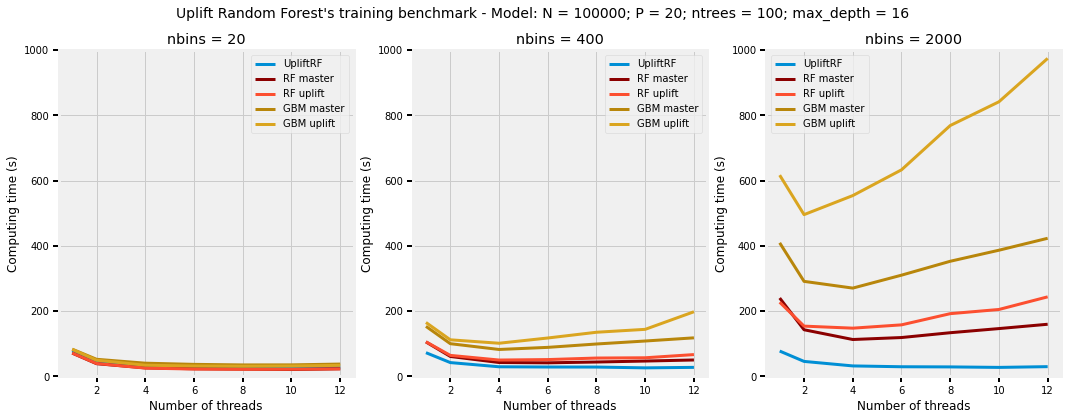

In [46]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 37.50852211316427, 10: 35.030277967453, 8: 34.86528261502584, 6: 36.60028958320618, 4: 40.20812519391378, 2: 52.12816262245178, 1: 83.14791385332744}, {12: 117.91347622871399, 10: 108.18607719739278, 8: 99.06194106737773, 6: 88.699365456899, 4: 82.25684571266174, 2: 99.99014337857564, 1: 153.11695392926535}, {12: 423.15793108940125, 10: 386.56732908884686, 8: 352.6941713492076, 6: 310.0572675863902, 4: 270.4135835965474, 2: 291.05263535181683, 1: 409.2192578315735}]
all_predict_rf_master = [{12: 23.081782182057697, 10: 20.782241741816204, 8: 22.05728014310201, 6: 23.16396387418111, 4: 25.820770263671875, 2: 38.65766922632853, 1: 71.11836949984233}, {12: 50.03956437110901, 10: 46.765750328699745, 8: 43.79192964235941, 6: 41.32944862047831, 4: 42.279480854670204, 2: 60.84646725654602, 1: 105.355384349823}, {12: 159.5656851132711, 10: 146.31372928619385, 8: 133.61287609736124, 6: 118.84597039222717, 4: 112.81829539934795, 2: 142.7178599834442, 1: 239.9582793712616}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

## Evaluation Stage

In [28]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [29]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw7809vsk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw7809vsk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw7809vsk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_ddlk4d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23049330711364746s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2167036533355713s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22375726699829102s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22356796264648438s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22729063034057617s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22310757637023926s
extended

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_3vas1m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23223519325256348s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23762249946594238s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2152407169342041s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23165631294250488s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2241830825805664s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23717117309570312s
extendedi

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_to27jy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.21689462661743164s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23179078102111816s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22240042686462402s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23810935020446777s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2400197982788086s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.242384672164917s
extendedis

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_qlcm7u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.21479320526123047s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2327268123626709s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22777771949768066s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23469829559326172s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22941017150878906s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2256166934967041s
extendedi

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_p7ie5w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.21538186073303223s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.21674704551696777s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22218751907348633s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23126888275146484s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23210573196411133s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23929476737976074s
extende

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_zwt35m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2344532012939453s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22689390182495117s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22999238967895508s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22487354278564453s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22185039520263672s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24271535873413086s
extended

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_u1uqnw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23218631744384766s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23861217498779297s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22374439239501953s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22197580337524414s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23235583305358887s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2079012393951416s
extended

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_b73vfr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.223588228225708s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24230241775512695s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2316744327545166s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23270773887634277s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22588491439819336s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23142027854919434s
extendedis

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_asvm10
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2326045036315918s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23197674751281738s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22687983512878418s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23868131637573242s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.235795259475708s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24257993698120117s
extendedis

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_gh40bv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23629546165466309s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2262716293334961s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23978662490844727s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2234182357788086s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.23531627655029297s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24454736709594727s
extendedi

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_e6ie4d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.21657633781433105s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.2371845245361328s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.236114501953125s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.22856712341308594s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2514314651489258s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24257874488830566s
extendediso

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_otlhbg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
extendedisolationforest Model Build progress: |███████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.22859525680541992s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23430156707763672s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.2440791130065918s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.23873376846313477s
extendedisolationforest prediction progress: |████████████████████████████| 100%
EIF Time: 0.24263310432434082s
isolationforest prediction progress: |████████████████████████████████████| 100%
IF Time: 0.24220037460327148s
extended

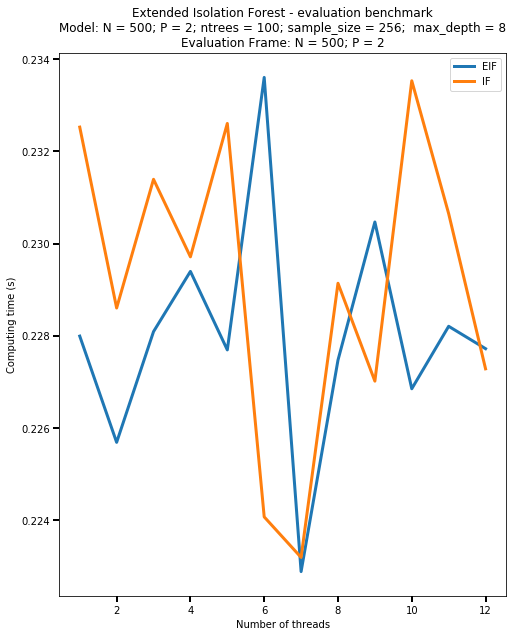

In [30]:
plot_predict(eif_time18, if_time18)

In [31]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx8rakjqu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx8rakjqu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx8rakjqu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_b7sgqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


MemoryError: 

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()